In [6]:
import sys
import os

# Define the path to your folder
folder_path = f'..\\..\\..\\Models\\AutoDiffusion' 

# Add the folder to sys.path
sys.path.append(folder_path)

In [7]:
import numpy as np
#import process_edited as pce
import process_GQ as pce
import autoencoder as ae
import diffusion as diff
import TabDDPMdiff as TabDiff
import pandas as pd
import torch
import os
import time
import numpy as np

In [ ]:
strings_set = {'diabetes','spambase','creditcard_sampled','HTRU','mammography'}
dataset='diabetes'
Model = 'AutoDiff'
metrics_list = []
sample_size_percent_list = [30, 50,70, 100]
for sample_size_percent in sample_size_percent_list:
    
    print(f"Recall Score for AutoDiff Autoencoder & ForestDIffusion for {dataset} dataset with augmentation ratio {sample_size_percent}%")
    file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
    # Read dataframe
    # print(file_path)
    real_df = pd.read_csv(file_path)
    #real_df = real_df.drop('url', axis=1)
    # # Step 2: Inspect the data and check for class imbalance
    # # Assuming the last column is the label, and the rest are features
    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values  # Labels (binary classification)
    #  # Separate the minority class
    # Find the minority class
    
    real_minortiy = real_df[y == 1]

    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_minortiy, threshold)
    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' #@param {'type':'string'}
    n_epochs = 2000 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = real_minortiy.shape[0] # Full batch

    ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    from ForestDiffusion import ForestDiffusionModel


    # Convert to NumPy array
    array = latent_features.detach().cpu().numpy()
    forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
    minority_fake = forest_model.generate(batch_size=len(real_minortiy)) # Adjust the batch size to create a balanced dataset
    sample=torch.tensor(minority_fake, dtype=torch.float32)
    sample.shape
    gen_output = ds[0](sample, ds[2], ds[3])
    gen_df = pce.convert_to_table(real_minortiy, gen_output, threshold)

    output_directory =  f'..\\..\\..\\Datasets\\Synthetic Data\\'
    filename = f'{Model}+Forest_{dataset}_Synthetic.csv'
    output_file = os.path.join(output_directory, filename)
    # gen_df.to_csv(output_file, index=False) 


    # Select a random sample of the generated data
    num_samples_to_generate = len(real_minortiy)*sample_size_percent // 100
    selected_samples = gen_df.sample(n=num_samples_to_generate, random_state=42)  # For reproducibility
    # Syn _df will be the dataset after augmentation
    syn_df = pd.concat([real_df, selected_samples], ignore_index=True)


    augmented_output_directory =  f'..\\..\\..\\Datasets\\Augmented Data\\'
    filename = f'{Model}+Forest_{dataset}_Augmented.csv'
    augmented_output_file = os.path.join(augmented_output_directory, filename)
    # syn_df.to_csv(augmented_output_file, index=False) 

    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt
    from ForestDiffusion import ForestDiffusionModel
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import recall_score, f1_score

    # real_df = pd.read_csv(filename)
    # syn_filename = f'{string}/{Model}_{string}_Augmented.csv'

    # augmented_df = pd.read_csv(syn_filename)
    augmented_df=syn_df

    
    # Check and print the original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist_before = dict(zip(unique, counts))
    print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

    X_balanced = augmented_df.iloc[:, :-1].values  # Features
    y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

    # Check and print the Augmented class distribution
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    prec_orig = precision_score(y_test_orig, y_pred_orig)
    prec_bal = precision_score(y_test_orig, y_pred_bal)
    
    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    # f1_orig = f1_score(y_test_orig, y_pred_orig)
    # f1_bal = f1_score(y_test_orig, y_pred_bal)

    # Step 9: Print and store the performance metrics
    # Store metrics in a dictionary
    metrics = {
    "Dataset": dataset,
    "Augmentaion Ratio":f'{sample_size_percent}%',
    "Recall_Original": recall_orig,
    "Recall_Generated": recalls_bal,
    
    }

    # Append the dictionary to the list
    metrics_list.append(metrics)
    recall_list.append(recalls_bal)
   
# Convert the list of dictionaries into a DataFrame
import matplotlib.pyplot as plt

# Create the plot
plt.plot(sample_size_percent_list, recall_list, marker='o', linestyle='-', color='b', label='Recall Score (Minor Class)')
# Adding title and labels
plt.title(f'Recall Score vs Augmentation Ratio \n at 2000 epochs \n for {dataset} dataset')
plt.xlabel('Augmentation Ratio')
plt.ylabel('Recall Score (Augmented Data)')
plt.legend(loc="upper left")

# Show the grid
plt.grid()

# Display the plot

diagram_name=f'Recall Score vs Augmentation Ratio for {dataset} dataset(AutoDiffandForest).png'
plt.savefig(diagram_name)
plt.show()


Recall Score for AutoDiff Autoencoder & ForestDIffusion for diabetes dataset with augmentation ratio 30%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 348}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for diabetes dataset with augmentation ratio 50%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 402}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for diabetes dataset with augmentation ratio 70%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 455}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for diabetes dataset with augmentation ratio 100%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 536}


In [14]:
import pandas as pd
metrics_df = pd.DataFrame(metrics_list)
# Print the DataFrame
print(metrics_df)

    Dataset Augmentaion Ratio  Recall_Original  Recall_Generated
0  diabetes               30%           0.6625            0.7125
1  diabetes               50%           0.6625            0.8125
2  diabetes               70%           0.6625            0.8250
3  diabetes              100%           0.6625            0.8875


In [15]:
strings_set = {'diabetes','spambase','creditcard_sampled','HTRU','mammography'}
dataset='HTRU'
Model = 'AutoDiff'
sample_size_percent_list = [30, 50,70, 100]
for sample_size_percent in sample_size_percent_list:
    
    print(f"Recall Score for AutoDiff Autoencoder & ForestDIffusion for {dataset} dataset with augmentation ratio {sample_size_percent}%")
    file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
    # Read dataframe
    # print(file_path)
    real_df = pd.read_csv(file_path)
    #real_df = real_df.drop('url', axis=1)
    # # Step 2: Inspect the data and check for class imbalance
    # # Assuming the last column is the label, and the rest are features
    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values  # Labels (binary classification)
    #  # Separate the minority class
    # Find the minority class
    
    real_minortiy = real_df[y == 1]

    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_minortiy, threshold)
    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' #@param {'type':'string'}
    n_epochs = 2000 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = real_minortiy.shape[0] # Full batch

    ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    from ForestDiffusion import ForestDiffusionModel


    # Convert to NumPy array
    array = latent_features.detach().cpu().numpy()
    forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
    minority_fake = forest_model.generate(batch_size=len(real_minortiy)) # Adjust the batch size to create a balanced dataset
    sample=torch.tensor(minority_fake, dtype=torch.float32)
    sample.shape
    gen_output = ds[0](sample, ds[2], ds[3])
    gen_df = pce.convert_to_table(real_minortiy, gen_output, threshold)

    output_directory =  f'..\\..\\..\\Datasets\\Synthetic Data\\'
    filename = f'{Model}+Forest_{dataset}_Synthetic.csv'
    output_file = os.path.join(output_directory, filename)
    # gen_df.to_csv(output_file, index=False) 


    # Select a random sample of the generated data
    num_samples_to_generate = len(real_minortiy)*sample_size_percent // 100
    selected_samples = gen_df.sample(n=num_samples_to_generate, random_state=42)  # For reproducibility
    # Syn _df will be the dataset after augmentation
    syn_df = pd.concat([real_df, selected_samples], ignore_index=True)


    augmented_output_directory =  f'..\\..\\..\\Datasets\\Augmented Data\\'
    filename = f'{Model}+Forest_{dataset}_Augmented.csv'
    augmented_output_file = os.path.join(augmented_output_directory, filename)
    # syn_df.to_csv(augmented_output_file, index=False) 

    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt
    from ForestDiffusion import ForestDiffusionModel
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import recall_score, f1_score

    # real_df = pd.read_csv(filename)
    # syn_filename = f'{string}/{Model}_{string}_Augmented.csv'

    # augmented_df = pd.read_csv(syn_filename)
    augmented_df=syn_df

    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values 
    # Check and print the original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist_before = dict(zip(unique, counts))
    print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

    X_balanced = augmented_df.iloc[:, :-1].values  # Features
    y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

    # Check and print the Augmented class distribution
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    prec_orig = precision_score(y_test_orig, y_pred_orig)
    prec_bal = precision_score(y_test_orig, y_pred_bal)
    
    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    # f1_orig = f1_score(y_test_orig, y_pred_orig)
    # f1_bal = f1_score(y_test_orig, y_pred_bal)

    # Step 9: Print and store the performance metrics
    # Store metrics in a dictionary
    metrics = {
    "Dataset": dataset,
    "Augmentaion Ratio":f'{sample_size_percent}%',
    "Recall_Original": recall_orig,
    "Recall_Generated": recalls_bal,
    
    }

    # Append the dictionary to the list
    metrics_list.append(metrics)
    recall_list.append(recalls_bal)
    # print(f"Precision score (original data): {prec_orig:.4f}")
    # print(f"Precision score (generated data): {prec_bal:.4f}")
    # print(f"Recall score (original data): {recall_orig:.4f}")
    # print(f"Recall score (generated data): {recalls_bal:.4f}")
    # print(f"F1 score (original data): {f1_orig:.4f}")
    # print(f"F1 score (generated data): {f1_bal:.4f}")
    # print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    # print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


    # print(f"Number of fake samples generated: {len(augmented_df)-len(real_df)}")
# Convert the list of dictionaries into a DataFrame
import matplotlib.pyplot as plt

# Create the plot
plt.plot(sample_size_percent_list, recall_list, marker='o', linestyle='-', color='b', label='Recall Score (Minor Class)')
# plt.plot(batch_size_list, major_class_data_recall_score_list, marker='o', linestyle='-', color='r', label='Recall Score (Major Class)')
# Adding title and labels
plt.title(f'Recall Score vs Augmentation Ratio \n at 2000 epochs \n for {dataset} dataset')
plt.xlabel('Augmentation Ratio')
plt.ylabel('Recall Score (Augmented Data)')
plt.legend(loc="upper left")

# Show the grid
plt.grid()

# Display the plot

diagram_name=f'Recall Score vs Augmentation Ratio for {dataset} dataset(AutoDiffandForest).png'
plt.savefig(diagram_name)
plt.show()

Recall Score for AutoDiff Autoencoder & ForestDIffusion for HTRU dataset with augmentation ratio 30%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 16259, 1: 1639}
Class distribution after augmentation: {0.0: 16259, 1.0: 2130}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for HTRU dataset with augmentation ratio 50%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 16259, 1: 1639}
Class distribution after augmentation: {0.0: 16259, 1.0: 2458}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for HTRU dataset with augmentation ratio 70%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 16259, 1: 1639}
Class distribution after augmentation: {0.0: 16259, 1.0: 2786}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for HTRU dataset with augmentation ratio 100%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 16259, 1: 1639}
Class distribution after augmentation: {0.0: 16259, 1.0: 3278}


NameError: name 'recall_list' is not defined

In [16]:
metrics_df = pd.DataFrame(metrics_list)
# Print the DataFrame
print(metrics_df)

    Dataset Augmentaion Ratio  Recall_Original  Recall_Generated
0  diabetes               30%         0.662500          0.712500
1  diabetes               50%         0.662500          0.812500
2  diabetes               70%         0.662500          0.825000
3  diabetes              100%         0.662500          0.887500
4      HTRU               30%         0.835391          0.884774
5      HTRU               50%         0.835391          0.907407
6      HTRU               70%         0.835391          0.911523
7      HTRU              100%         0.835391          0.917695


In [17]:
strings_set = {'diabetes','spambase','creditcard_sampled','HTRU','mammography'}
dataset='mammography'
Model = 'AutoDiff'
recall_list = []
sample_size_percent_list = [30, 50,70, 100]
for sample_size_percent in sample_size_percent_list:
    
    print(f"Recall Score for AutoDiff Autoencoder & ForestDIffusion for {dataset} dataset")
    file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
    # Read dataframe
    # print(file_path)
    real_df = pd.read_csv(file_path)
    #real_df = real_df.drop('url', axis=1)
    # # Step 2: Inspect the data and check for class imbalance
    # # Assuming the last column is the label, and the rest are features
    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values  # Labels (binary classification)
    #  # Separate the minority class
    # Find the minority class
    
    real_minortiy = real_df[y == 1]

    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_minortiy, threshold)
    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' #@param {'type':'string'}
    n_epochs = 2000 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = real_minortiy.shape[0] # Full batch

    ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    from ForestDiffusion import ForestDiffusionModel


    # Convert to NumPy array
    array = latent_features.detach().cpu().numpy()
    forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
    minority_fake = forest_model.generate(batch_size=len(real_minortiy)) # Adjust the batch size to create a balanced dataset
    sample=torch.tensor(minority_fake, dtype=torch.float32)
    sample.shape
    gen_output = ds[0](sample, ds[2], ds[3])
    gen_df = pce.convert_to_table(real_minortiy, gen_output, threshold)

    output_directory =  f'..\\..\\..\\Datasets\\Synthetic Data\\'
    filename = f'{Model}+Forest_{dataset}_Synthetic.csv'
    output_file = os.path.join(output_directory, filename)
    # gen_df.to_csv(output_file, index=False) 


    # Select a random sample of the generated data
    num_samples_to_generate = len(real_minortiy)*sample_size_percent // 100
    selected_samples = gen_df.sample(n=num_samples_to_generate, random_state=42)  # For reproducibility
    # Syn _df will be the dataset after augmentation
    syn_df = pd.concat([real_df, selected_samples], ignore_index=True)


    augmented_output_directory =  f'..\\..\\..\\Datasets\\Augmented Data\\'
    filename = f'{Model}+Forest_{dataset}_Augmented.csv'
    augmented_output_file = os.path.join(augmented_output_directory, filename)
    # syn_df.to_csv(augmented_output_file, index=False) 

    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt
    from ForestDiffusion import ForestDiffusionModel
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import recall_score, f1_score

    # real_df = pd.read_csv(filename)
    # syn_filename = f'{string}/{Model}_{string}_Augmented.csv'

    # augmented_df = pd.read_csv(syn_filename)
    augmented_df=syn_df

    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values 
    # Check and print the original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist_before = dict(zip(unique, counts))
    print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

    X_balanced = augmented_df.iloc[:, :-1].values  # Features
    y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

    # Check and print the Augmented class distribution
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    prec_orig = precision_score(y_test_orig, y_pred_orig)
    prec_bal = precision_score(y_test_orig, y_pred_bal)
    
    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    # f1_orig = f1_score(y_test_orig, y_pred_orig)
    # f1_bal = f1_score(y_test_orig, y_pred_bal)

    # Step 9: Print and store the performance metrics
    # Store metrics in a dictionary
    metrics = {
    "Dataset": dataset,
    "Augmentaion Ratio":f'{sample_size_percent}%',
    "Recall_Original": recall_orig,
    "Recall_Generated": recalls_bal,
    
    }

    # Append the dictionary to the list
    metrics_list.append(metrics)
    recall_list.append(recalls_bal)
    # print(f"Precision score (original data): {prec_orig:.4f}")
    # print(f"Precision score (generated data): {prec_bal:.4f}")
    # print(f"Recall score (original data): {recall_orig:.4f}")
    # print(f"Recall score (generated data): {recalls_bal:.4f}")
    # print(f"F1 score (original data): {f1_orig:.4f}")
    # print(f"F1 score (generated data): {f1_bal:.4f}")
    # print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    # print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


    # print(f"Number of fake samples generated: {len(augmented_df)-len(real_df)}")
# Convert the list of dictionaries into a DataFrame
import matplotlib.pyplot as plt

# Create the plot
plt.plot(sample_size_percent_list, recall_list, marker='o', linestyle='-', color='b', label='Recall Score (Minor Class)')
# plt.plot(batch_size_list, major_class_data_recall_score_list, marker='o', linestyle='-', color='r', label='Recall Score (Major Class)')
# Adding title and labels
plt.title(f'Recall Score vs Augmentation Ratio \n at 2000 epochs \n for {dataset} dataset')
plt.xlabel('Augmentation Ratio')
plt.ylabel('Recall Score (Augmented Data)')
plt.legend(loc="upper left")

# Show the grid
plt.grid()

# Display the plot

diagram_name=f'Recall Score vs Augmentation Ratio for {dataset} dataset(AutoDiffandForest).png'
plt.savefig(diagram_name)
plt.show()

Recall Score for AutoDiff Autoencoder & ForestDIffusion for mammography dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {-1: 10923, 1: 260}
Class distribution after augmentation: {-1.0: 10923, 1.0: 338}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for mammography dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {-1: 10923, 1: 260}
Class distribution after augmentation: {-1.0: 10923, 1.0: 390}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for mammography dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {-1: 10923, 1: 260}
Class distribution after augmentation: {-1.0: 10923, 1.0: 442}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for mammography dataset


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {-1: 10923, 1: 260}
Class distribution after augmentation: {-1.0: 10923, 1.0: 520}


NameError: name 'recall_list' is not defined

In [18]:
metrics_df = pd.DataFrame(metrics_list)
# Print the DataFrame
print(metrics_df)

        Dataset Augmentaion Ratio  Recall_Original  Recall_Generated
0      diabetes               30%         0.662500          0.712500
1      diabetes               50%         0.662500          0.812500
2      diabetes               70%         0.662500          0.825000
3      diabetes              100%         0.662500          0.887500
4          HTRU               30%         0.835391          0.884774
5          HTRU               50%         0.835391          0.907407
6          HTRU               70%         0.835391          0.911523
7          HTRU              100%         0.835391          0.917695
8   mammography               30%         0.594595          0.702703
9   mammography               50%         0.594595          0.729730
10  mammography               70%         0.594595          0.770270
11  mammography              100%         0.594595          0.810811


Recall Score for AutoDiff Autoencoder & ForestDIffusion for creditcard_sampled dataset with augmentation ratio 30%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 4000, 1: 50}
Class distribution after augmentation: {0.0: 4000, 1.0: 65}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for creditcard_sampled dataset with augmentation ratio 50%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 4000, 1: 50}
Class distribution after augmentation: {0.0: 4000, 1.0: 75}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for creditcard_sampled dataset with augmentation ratio 70%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 4000, 1: 50}
Class distribution after augmentation: {0.0: 4000, 1.0: 85}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for creditcard_sampled dataset with augmentation ratio 100%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 4000, 1: 50}
Class distribution after augmentation: {0.0: 4000, 1.0: 100}


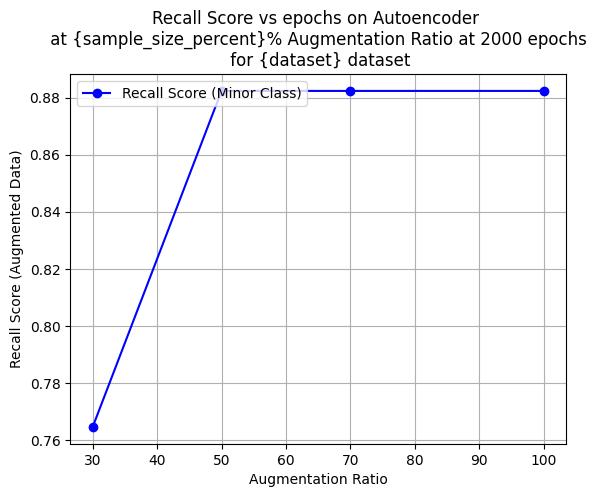

In [19]:
strings_set = {'diabetes','spambase','creditcard_sampled','HTRU','mammography'}
dataset='creditcard_sampled'
Model = 'AutoDiff'
recall_list = []
sample_size_percent_list = [30, 50,70, 100]
for sample_size_percent in sample_size_percent_list:
    
    print(f"Recall Score for AutoDiff Autoencoder & ForestDIffusion for {dataset} dataset with augmentation ratio {sample_size_percent}%")
    file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
    # Read dataframe
    # print(file_path)
    real_df = pd.read_csv(file_path)
    #real_df = real_df.drop('url', axis=1)
    # # Step 2: Inspect the data and check for class imbalance
    # # Assuming the last column is the label, and the rest are features
    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values  # Labels (binary classification)
    #  # Separate the minority class
    # Find the minority class
    
    real_minortiy = real_df[y == 1]

    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_minortiy, threshold)
    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' #@param {'type':'string'}
    n_epochs = 2000 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = real_minortiy.shape[0] # Full batch

    ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    from ForestDiffusion import ForestDiffusionModel


    # Convert to NumPy array
    array = latent_features.detach().cpu().numpy()
    forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
    minority_fake = forest_model.generate(batch_size=len(real_minortiy)) # Adjust the batch size to create a balanced dataset
    sample=torch.tensor(minority_fake, dtype=torch.float32)
    sample.shape
    gen_output = ds[0](sample, ds[2], ds[3])
    gen_df = pce.convert_to_table(real_minortiy, gen_output, threshold)

    output_directory =  f'..\\..\\..\\Datasets\\Synthetic Data\\'
    filename = f'{Model}+Forest_{dataset}_Synthetic.csv'
    output_file = os.path.join(output_directory, filename)
    # gen_df.to_csv(output_file, index=False) 


    # Select a random sample of the generated data
    num_samples_to_generate = len(real_minortiy)*sample_size_percent // 100
    selected_samples = gen_df.sample(n=num_samples_to_generate, random_state=42)  # For reproducibility
    # Syn _df will be the dataset after augmentation
    syn_df = pd.concat([real_df, selected_samples], ignore_index=True)


    augmented_output_directory =  f'..\\..\\..\\Datasets\\Augmented Data\\'
    filename = f'{Model}+Forest_{dataset}_Augmented.csv'
    augmented_output_file = os.path.join(augmented_output_directory, filename)
    # syn_df.to_csv(augmented_output_file, index=False) 

    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt
    from ForestDiffusion import ForestDiffusionModel
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import recall_score, f1_score

    # real_df = pd.read_csv(filename)
    # syn_filename = f'{string}/{Model}_{string}_Augmented.csv'

    # augmented_df = pd.read_csv(syn_filename)
    augmented_df=syn_df

    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values 
    # Check and print the original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist_before = dict(zip(unique, counts))
    print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

    X_balanced = augmented_df.iloc[:, :-1].values  # Features
    y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

    # Check and print the Augmented class distribution
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    prec_orig = precision_score(y_test_orig, y_pred_orig)
    prec_bal = precision_score(y_test_orig, y_pred_bal)
    
    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    # f1_orig = f1_score(y_test_orig, y_pred_orig)
    # f1_bal = f1_score(y_test_orig, y_pred_bal)

    # Step 9: Print and store the performance metrics
    # Store metrics in a dictionary
    metrics = {
    "Dataset": dataset,
    "Augmentaion Ratio":f'{sample_size_percent}%',
    "Recall_Original": recall_orig,
    "Recall_Generated": recalls_bal,
    
    }

    # Append the dictionary to the list
    metrics_list.append(metrics)
    recall_list.append(recalls_bal)
    # print(f"Precision score (original data): {prec_orig:.4f}")
    # print(f"Precision score (generated data): {prec_bal:.4f}")
    # print(f"Recall score (original data): {recall_orig:.4f}")
    # print(f"Recall score (generated data): {recalls_bal:.4f}")
    # print(f"F1 score (original data): {f1_orig:.4f}")
    # print(f"F1 score (generated data): {f1_bal:.4f}")
    # print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    # print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


    # print(f"Number of fake samples generated: {len(augmented_df)-len(real_df)}")
# Convert the list of dictionaries into a DataFrame
import matplotlib.pyplot as plt

# Create the plot
plt.plot(sample_size_percent_list, recall_list, marker='o', linestyle='-', color='b', label='Recall Score (Minor Class)')
# plt.plot(batch_size_list, major_class_data_recall_score_list, marker='o', linestyle='-', color='r', label='Recall Score (Major Class)')
# Adding title and labels
plt.title(f'Recall Score vs Augmentation Ratio \n at 2000 epochs \n for {dataset} dataset')
plt.xlabel('Augmentation Ratio')
plt.ylabel('Recall Score (Augmented Data)')
plt.legend(loc="upper left")

# Show the grid
plt.grid()

# Display the plot

diagram_name=f'Recall Score vs Augmentation Ratio for {dataset} dataset(AutoDiffandForest).png'
plt.savefig(diagram_name)
plt.show()

In [20]:
metrics_df = pd.DataFrame(metrics_list)
# Print the DataFrame
print(metrics_df)

               Dataset Augmentaion Ratio  Recall_Original  Recall_Generated
0             diabetes               30%         0.662500          0.712500
1             diabetes               50%         0.662500          0.812500
2             diabetes               70%         0.662500          0.825000
3             diabetes              100%         0.662500          0.887500
4                 HTRU               30%         0.835391          0.884774
5                 HTRU               50%         0.835391          0.907407
6                 HTRU               70%         0.835391          0.911523
7                 HTRU              100%         0.835391          0.917695
8          mammography               30%         0.594595          0.702703
9          mammography               50%         0.594595          0.729730
10         mammography               70%         0.594595          0.770270
11         mammography              100%         0.594595          0.810811
12  creditca

In [ ]:
strings_set = {'diabetes','spambase','creditcard_sampled','HTRU','mammography'}
dataset='spambase'
Model = 'AutoDiff'
recall_list = []
sample_size_percent_list = [30, 50,70, 100]
for sample_size_percent in sample_size_percent_list:
    
    print(f"Recall Score for AutoDiff Autoencoder & ForestDIffusion for {dataset} dataset with augmentation ratio {sample_size_percent}%")
    file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
    # Read dataframe
    # print(file_path)
    real_df = pd.read_csv(file_path)
    #real_df = real_df.drop('url', axis=1)
    # # Step 2: Inspect the data and check for class imbalance
    # # Assuming the last column is the label, and the rest are features
    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values  # Labels (binary classification)
    #  # Separate the minority class
    # Find the minority class
    
    real_minortiy = real_df[y == 1]

    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_minortiy, threshold)
    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' #@param {'type':'string'}
    n_epochs = 2000 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = real_minortiy.shape[0] # Full batch

    ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    from ForestDiffusion import ForestDiffusionModel


    # Convert to NumPy array
    array = latent_features.detach().cpu().numpy()
    forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
    minority_fake = forest_model.generate(batch_size=len(real_minortiy)) # Adjust the batch size to create a balanced dataset
    sample=torch.tensor(minority_fake, dtype=torch.float32)
    sample.shape
    gen_output = ds[0](sample, ds[2], ds[3])
    gen_df = pce.convert_to_table(real_minortiy, gen_output, threshold)

    output_directory =  f'..\\..\\..\\Datasets\\Synthetic Data\\'
    filename = f'{Model}+Forest_{dataset}_Synthetic.csv'
    output_file = os.path.join(output_directory, filename)
    # gen_df.to_csv(output_file, index=False) 


    # Select a random sample of the generated data
    num_samples_to_generate = len(real_minortiy)*sample_size_percent // 100
    selected_samples = gen_df.sample(n=num_samples_to_generate, random_state=42)  # For reproducibility
    # Syn _df will be the dataset after augmentation
    syn_df = pd.concat([real_df, selected_samples], ignore_index=True)


    augmented_output_directory =  f'..\\..\\..\\Datasets\\Augmented Data\\'
    filename = f'{Model}+Forest_{dataset}_Augmented.csv'
    augmented_output_file = os.path.join(augmented_output_directory, filename)
    # syn_df.to_csv(augmented_output_file, index=False) 

    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt
    from ForestDiffusion import ForestDiffusionModel
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import recall_score, f1_score

    # real_df = pd.read_csv(filename)
    # syn_filename = f'{string}/{Model}_{string}_Augmented.csv'

    # augmented_df = pd.read_csv(syn_filename)
    augmented_df=syn_df

    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values 
    # Check and print the original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist_before = dict(zip(unique, counts))
    print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

    X_balanced = augmented_df.iloc[:, :-1].values  # Features
    y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

    # Check and print the Augmented class distribution
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    prec_orig = precision_score(y_test_orig, y_pred_orig)
    prec_bal = precision_score(y_test_orig, y_pred_bal)
    
    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    # f1_orig = f1_score(y_test_orig, y_pred_orig)
    # f1_bal = f1_score(y_test_orig, y_pred_bal)

    # Step 9: Print and store the performance metrics
    # Store metrics in a dictionary
    metrics = {
    "Dataset": dataset,
    "Augmentaion Ratio":f'{sample_size_percent}%',
    "Recall_Original": recall_orig,
    "Recall_Generated": recalls_bal,
    
    }

    # Append the dictionary to the list
    metrics_list.append(metrics)
    recall_list.append(recalls_bal)
    # print(f"Precision score (original data): {prec_orig:.4f}")
    # print(f"Precision score (generated data): {prec_bal:.4f}")
    # print(f"Recall score (original data): {recall_orig:.4f}")
    # print(f"Recall score (generated data): {recalls_bal:.4f}")
    # print(f"F1 score (original data): {f1_orig:.4f}")
    # print(f"F1 score (generated data): {f1_bal:.4f}")
    # print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    # print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


    # print(f"Number of fake samples generated: {len(augmented_df)-len(real_df)}")
# Convert the list of dictionaries into a DataFrame
import matplotlib.pyplot as plt

# Create the plot
plt.plot(sample_size_percent_list, recall_list, marker='o', linestyle='-', color='b', label='Recall Score (Minor Class)')
# plt.plot(batch_size_list, major_class_data_recall_score_list, marker='o', linestyle='-', color='r', label='Recall Score (Major Class)')
# Adding title and labels
plt.title(f'Recall Score vs Augmentation Ratio \n at 2000 epochs \n for {dataset} dataset')
plt.xlabel('Augmentation Ratio')
plt.ylabel('Recall Score (Augmented Data)')
plt.legend(loc="upper left")

# Show the grid
plt.grid()

# Display the plot

diagram_name=f'Recall Score vs Augmentation Ratio for {dataset} dataset(AutoDiffandForest).png'
plt.savefig(diagram_name)
plt.show()

In [ ]:
metrics_df = pd.DataFrame(metrics_list)
# Print the DataFrame
print(metrics_df)

Diabetes_Reduced

Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced diabetes dataset with augmentation ratio 50%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 368}
Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced diabetes dataset with augmentation ratio 100%


  0%|          | 0/2000 [00:00<?, ?it/s]

Class distribution before augmentation: {0: 500, 1: 268}
Class distribution after augmentation: {0.0: 500, 1.0: 468}


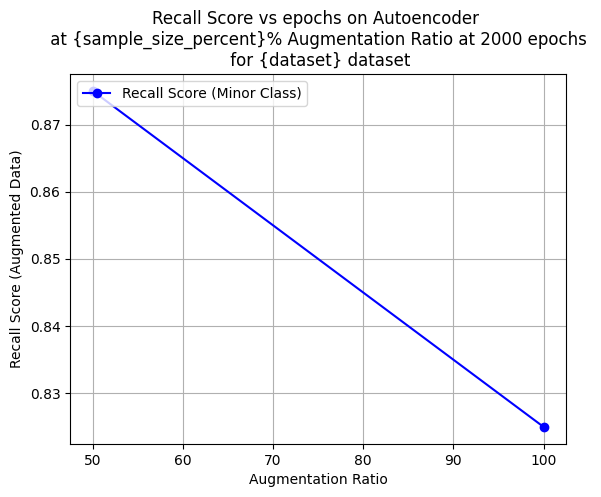

In [23]:
strings_set = {'diabetes','spambase','creditcard_sampled','HTRU','mammography'}
dataset='diabetes'
Model = 'AutoDiff'
recall_list = []
sample_size_percent_list = [50, 100]
for sample_size_percent in sample_size_percent_list:
    
    print(f"Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced {dataset} dataset with augmentation ratio {sample_size_percent}%")
    file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
    # Read dataframe
    # print(file_path)
    real_df = pd.read_csv(file_path)
    #real_df = real_df.drop('url', axis=1)
    # # Step 2: Inspect the data and check for class imbalance
    # # Assuming the last column is the label, and the rest are features
    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values  # Labels (binary classification)
    #  # Separate the minority class
    # Find the minority class
    
    real_minortiy_whole = real_df[y == 1]
    real_minortiy = real_minortiy_whole.sample(n=len(real_minortiy_whole) - 68, random_state=42)

    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_minortiy, threshold)
    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' #@param {'type':'string'}
    n_epochs = 2000 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = real_minortiy.shape[0] # Full batch

    ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    from ForestDiffusion import ForestDiffusionModel


    # Convert to NumPy array
    array = latent_features.detach().cpu().numpy()
    forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
    minority_fake = forest_model.generate(batch_size=len(real_minortiy)) # Adjust the batch size to create a balanced dataset
    sample=torch.tensor(minority_fake, dtype=torch.float32)
    sample.shape
    gen_output = ds[0](sample, ds[2], ds[3])
    gen_df = pce.convert_to_table(real_minortiy, gen_output, threshold)

    output_directory =  f'..\\..\\..\\Datasets\\Synthetic Data\\'
    filename = f'{Model}+Forest_{dataset}_Synthetic.csv'
    output_file = os.path.join(output_directory, filename)
    # gen_df.to_csv(output_file, index=False) 


    # Select a random sample of the generated data
    num_samples_to_generate = len(real_minortiy)*sample_size_percent // 100
    selected_samples = gen_df.sample(n=num_samples_to_generate, random_state=42)  # For reproducibility
    # Syn _df will be the dataset after augmentation
    syn_df = pd.concat([real_df, selected_samples], ignore_index=True)


    augmented_output_directory =  f'..\\..\\..\\Datasets\\Augmented Data\\'
    filename = f'{Model}+Forest_{dataset}_Augmented.csv'
    augmented_output_file = os.path.join(augmented_output_directory, filename)
    # syn_df.to_csv(augmented_output_file, index=False) 

    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt
    from ForestDiffusion import ForestDiffusionModel
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import recall_score, f1_score

    # real_df = pd.read_csv(filename)
    # syn_filename = f'{string}/{Model}_{string}_Augmented.csv'

    # augmented_df = pd.read_csv(syn_filename)
    augmented_df=syn_df

    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values 
    # Check and print the original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist_before = dict(zip(unique, counts))
    print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

    X_balanced = augmented_df.iloc[:, :-1].values  # Features
    y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

    # Check and print the Augmented class distribution
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    prec_orig = precision_score(y_test_orig, y_pred_orig)
    prec_bal = precision_score(y_test_orig, y_pred_bal)
    
    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    # f1_orig = f1_score(y_test_orig, y_pred_orig)
    # f1_bal = f1_score(y_test_orig, y_pred_bal)

    # Step 9: Print and store the performance metrics
    # Store metrics in a dictionary
    metrics = {
    "Dataset": dataset,
    "Augmentaion Ratio":f'{sample_size_percent}%',
    "Recall_Original": recall_orig,
    "Recall_Generated": recalls_bal,
    
    }

    # Append the dictionary to the list
    metrics_list.append(metrics)
    recall_list.append(recalls_bal)
    # print(f"Precision score (original data): {prec_orig:.4f}")
    # print(f"Precision score (generated data): {prec_bal:.4f}")
    # print(f"Recall score (original data): {recall_orig:.4f}")
    # print(f"Recall score (generated data): {recalls_bal:.4f}")
    # print(f"F1 score (original data): {f1_orig:.4f}")
    # print(f"F1 score (generated data): {f1_bal:.4f}")
    # print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    # print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


    # print(f"Number of fake samples generated: {len(augmented_df)-len(real_df)}")
# Convert the list of dictionaries into a DataFrame
import matplotlib.pyplot as plt

# Create the plot
plt.plot(sample_size_percent_list, recall_list, marker='o', linestyle='-', color='b', label='Recall Score (Minor Class)')
# plt.plot(batch_size_list, major_class_data_recall_score_list, marker='o', linestyle='-', color='r', label='Recall Score (Major Class)')
# Adding title and labels
plt.title(f'Recall Score vs Augmentation Ratio \n at 2000 epochs \n for {dataset} dataset')
plt.xlabel('Augmentation Ratio')
plt.ylabel('Recall Score (Augmented Data)')
plt.legend(loc="upper left")

# Show the grid
plt.grid()

# Display the plot

diagram_name=f'Recall Score vs Augmentation Ratio for {dataset} dataset(AutoDiffandForest).png'
plt.savefig(diagram_name)
plt.show()

In [24]:
metrics_df = pd.DataFrame(metrics_list)
# Print the DataFrame
print(metrics_df)

               Dataset Augmentaion Ratio  Recall_Original  Recall_Generated
0             diabetes               30%         0.662500          0.712500
1             diabetes               50%         0.662500          0.812500
2             diabetes               70%         0.662500          0.825000
3             diabetes              100%         0.662500          0.887500
4                 HTRU               30%         0.835391          0.884774
5                 HTRU               50%         0.835391          0.907407
6                 HTRU               70%         0.835391          0.911523
7                 HTRU              100%         0.835391          0.917695
8          mammography               30%         0.594595          0.702703
9          mammography               50%         0.594595          0.729730
10         mammography               70%         0.594595          0.770270
11         mammography              100%         0.594595          0.810811
12  creditca

Reduced spambase

In [ ]:
strings_set = {'diabetes','spambase','creditcard_sampled','HTRU','mammography'}
dataset='spambase'
Model = 'AutoDiff'
recall_list = []
sample_size_percent_list = [30, 50,70, 100]
for sample_size_percent in sample_size_percent_list:
    
    print(f"Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced {dataset} dataset with augmentation ratio {sample_size_percent}%")
    file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
    # Read dataframe
    # print(file_path)
    real_df = pd.read_csv(file_path)
    #real_df = real_df.drop('url', axis=1)
    # # Step 2: Inspect the data and check for class imbalance
    # # Assuming the last column is the label, and the rest are features
    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values  # Labels (binary classification)
    #  # Separate the minority class
    # Find the minority class
    
    real_minortiy_whole = real_df[y == 1]
    real_minortiy = real_minortiy_whole.sample(n=len(minority_class) - 813, random_state=42)
    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_minortiy, threshold)
    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' #@param {'type':'string'}
    n_epochs = 2000 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = real_minortiy.shape[0] # Full batch

    ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    from ForestDiffusion import ForestDiffusionModel


    # Convert to NumPy array
    array = latent_features.detach().cpu().numpy()
    forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
    minority_fake = forest_model.generate(batch_size=len(real_minortiy)) # Adjust the batch size to create a balanced dataset
    sample=torch.tensor(minority_fake, dtype=torch.float32)
    sample.shape
    gen_output = ds[0](sample, ds[2], ds[3])
    gen_df = pce.convert_to_table(real_minortiy, gen_output, threshold)

    output_directory =  f'..\\..\\..\\Datasets\\Synthetic Data\\'
    filename = f'{Model}+Forest_{dataset}_Synthetic.csv'
    output_file = os.path.join(output_directory, filename)
    # gen_df.to_csv(output_file, index=False) 


    # Select a random sample of the generated data
    num_samples_to_generate = len(real_minortiy)*sample_size_percent // 100
    selected_samples = gen_df.sample(n=num_samples_to_generate, random_state=42)  # For reproducibility
    # Syn _df will be the dataset after augmentation
    syn_df = pd.concat([real_df, selected_samples], ignore_index=True)


    augmented_output_directory =  f'..\\..\\..\\Datasets\\Augmented Data\\'
    filename = f'{Model}+Forest_{dataset}_Augmented.csv'
    augmented_output_file = os.path.join(augmented_output_directory, filename)
    # syn_df.to_csv(augmented_output_file, index=False) 

    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt
    from ForestDiffusion import ForestDiffusionModel
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import recall_score, f1_score

    # real_df = pd.read_csv(filename)
    # syn_filename = f'{string}/{Model}_{string}_Augmented.csv'

    # augmented_df = pd.read_csv(syn_filename)
    augmented_df=syn_df

    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values 
    # Check and print the original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist_before = dict(zip(unique, counts))
    print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

    X_balanced = augmented_df.iloc[:, :-1].values  # Features
    y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

    # Check and print the Augmented class distribution
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    prec_orig = precision_score(y_test_orig, y_pred_orig)
    prec_bal = precision_score(y_test_orig, y_pred_bal)
    
    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    # f1_orig = f1_score(y_test_orig, y_pred_orig)
    # f1_bal = f1_score(y_test_orig, y_pred_bal)

    # Step 9: Print and store the performance metrics
    # Store metrics in a dictionary
    metrics = {
    "Dataset": dataset,
    "Augmentaion Ratio":f'{sample_size_percent}%',
    "Recall_Original": recall_orig,
    "Recall_Generated": recalls_bal,
    
    }

    # Append the dictionary to the list
    metrics_list.append(metrics)
    recall_list.append(recalls_bal)
    # print(f"Precision score (original data): {prec_orig:.4f}")
    # print(f"Precision score (generated data): {prec_bal:.4f}")
    # print(f"Recall score (original data): {recall_orig:.4f}")
    # print(f"Recall score (generated data): {recalls_bal:.4f}")
    # print(f"F1 score (original data): {f1_orig:.4f}")
    # print(f"F1 score (generated data): {f1_bal:.4f}")
    # print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    # print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


    # print(f"Number of fake samples generated: {len(augmented_df)-len(real_df)}")
# Convert the list of dictionaries into a DataFrame
import matplotlib.pyplot as plt

# Create the plot
plt.plot(sample_size_percent_list, recall_list, marker='o', linestyle='-', color='b', label='Recall Score (Minor Class)')
# plt.plot(batch_size_list, major_class_data_recall_score_list, marker='o', linestyle='-', color='r', label='Recall Score (Major Class)')
# Adding title and labels
plt.title(f'Recall Score vs Augmentation Ratio \n at 2000 epochs \n for {dataset} dataset')
plt.xlabel('Augmentation Ratio')
plt.ylabel('Recall Score (Augmented Data)')
plt.legend(loc="upper left")

# Show the grid
plt.grid()

# Display the plot

diagram_name=f'Recall Score vs Augmentation Ratio for {dataset} dataset(AutoDiffandForest).png'
plt.savefig(diagram_name)
plt.show()

In [ ]:
metrics_df = pd.DataFrame(metrics_list)
# Print the DataFrame
print(metrics_df)

In [25]:
import pandas as pd
metrics_df = pd.DataFrame(metrics_list)

# Save the DataFrame to a CSV file
metrics_df.to_csv("Auto_Diff_Forest_Different Augmentation Ratio at 2000 epochs.csv", index=False)

# Print the DataFrame
metrics_df

,Dataset,Augmentaion Ratio,Recall_Original,Recall_Generated
0,diabetes,30%,0.662500,0.712500
1,diabetes,50%,0.662500,0.812500
2,diabetes,70%,0.662500,0.825000
3,diabetes,100%,0.662500,0.887500
4,HTRU,30%,0.835391,0.884774
5,HTRU,50%,0.835391,0.907407
6,HTRU,70%,0.835391,0.911523
7,HTRU,100%,0.835391,0.917695
8,mammography,30%,0.594595,0.702703
9,mammography,50%,0.594595,0.729730


In [4]:
import sys
import os

# Define the path to your folder
folder_path = f'..\\..\\..\\Models\\AutoDiffusion' 

# Add the folder to sys.path
sys.path.append(folder_path)
import numpy as np
#import process_edited as pce
import process_GQ as pce
import autoencoder as ae
import diffusion as diff
import TabDDPMdiff as TabDiff
import pandas as pd
import torch
import os
import time
import numpy as np
strings_set = {'diabetes','spambase','creditcard_sampled','HTRU','mammography'}
dataset='oil'
Model = 'AutoDiff'
recall_list = []
sample_size_percent_list = [30, 50,70, 100]
for sample_size_percent in sample_size_percent_list:
    
    print(f"Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced {dataset} dataset with augmentation ratio {sample_size_percent}%")
    file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
    # Read dataframe
    # print(file_path)
    real_df = pd.read_csv(file_path)
    #real_df = real_df.drop('url', axis=1)
    # # Step 2: Inspect the data and check for class imbalance
    # # Assuming the last column is the label, and the rest are features
    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values  # Labels (binary classification)
    #  # Separate the minority class
    # Find the minority class
    
    real_minortiy_whole = real_df[y == 1]
    real_minortiy = real_minortiy_whole.sample(n=len(real_minority) - 813, random_state=42)
    threshold = 0.01 # Threshold for mixed-type variables
    parser = pce.DataFrameParser().fit(real_minortiy, threshold)
    ################################################################################################################
    # Auto-encoder hyper-parameters
    device = 'cuda' #@param {'type':'string'}
    n_epochs = 2000 #@param {'type':'integer'}
    eps = 1e-5 #@param {type:"number"}
    weight_decay = 1e-6 #@param {'type':'number'}
    maximum_learning_rate = 1e-2 #@param {'type':'number'}
    lr = 2e-4 #@param {'type':'number'}
    hidden_size = 250
    num_layers = 3
    batch_size = real_minortiy.shape[0] # Full batch

    ds = ae.train_autoencoder(real_minortiy, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold)
    latent_features = ds[1].detach()

    from ForestDiffusion import ForestDiffusionModel


    # Convert to NumPy array
    array = latent_features.detach().cpu().numpy()
    forest_model = ForestDiffusionModel(array, label_y=None, n_t=50, duplicate_K=100, bin_indexes=[], cat_indexes=[], int_indexes=[], diffusion_type='flow', n_jobs=-1)
    minority_fake = forest_model.generate(batch_size=len(real_minortiy)) # Adjust the batch size to create a balanced dataset
    sample=torch.tensor(minority_fake, dtype=torch.float32)
    sample.shape
    gen_output = ds[0](sample, ds[2], ds[3])
    gen_df = pce.convert_to_table(real_minortiy, gen_output, threshold)

    output_directory =  f'..\\..\\..\\Datasets\\Synthetic Data\\'
    filename = f'{Model}+Forest_{dataset}_Synthetic.csv'
    output_file = os.path.join(output_directory, filename)
    # gen_df.to_csv(output_file, index=False) 


    # Select a random sample of the generated data
    num_samples_to_generate = len(real_minortiy)*sample_size_percent // 100
    selected_samples = gen_df.sample(n=num_samples_to_generate, random_state=42)  # For reproducibility
    # Syn _df will be the dataset after augmentation
    syn_df = pd.concat([real_df, selected_samples], ignore_index=True)


    augmented_output_directory =  f'..\\..\\..\\Datasets\\Augmented Data\\'
    filename = f'{Model}+Forest_{dataset}_Augmented.csv'
    augmented_output_file = os.path.join(augmented_output_directory, filename)
    # syn_df.to_csv(augmented_output_file, index=False) 

    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt
    from ForestDiffusion import ForestDiffusionModel
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import recall_score, f1_score

    # real_df = pd.read_csv(filename)
    # syn_filename = f'{string}/{Model}_{string}_Augmented.csv'

    # augmented_df = pd.read_csv(syn_filename)
    augmented_df=syn_df

    X = real_df.iloc[:, :-1].values  # Features
    y = real_df.iloc[:, -1].values 
    # Check and print the original class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist_before = dict(zip(unique, counts))
    print(f"Class distribution before augmentation: {class_dist_before}")# Labels (binary classification)

    X_balanced = augmented_df.iloc[:, :-1].values  # Features
    y_balanced = augmented_df.iloc[:, -1].values  # Labels (binary classification)

    # Check and print the Augmented class distribution
    unique, counts = np.unique(y_balanced, return_counts=True)
    class_dist_after = dict(zip(unique, counts))
    print(f"Class distribution after augmentation: {class_dist_after}")

    # Step 6: Split the dataset into training and test sets (original and balanced)
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    # Step 7: Train a simple classifier on both original and generated datasets
    clf_orig = RandomForestClassifier(random_state=42)
    clf_orig.fit(X_train_orig, y_train_orig)

    clf_bal = RandomForestClassifier(random_state=42)
    clf_bal.fit(X_train_bal, y_train_bal)

    # Step 8: Predict and calculate recall and F1 scores
    y_pred_orig = clf_orig.predict(X_test_orig)
    y_pred_bal = clf_bal.predict(X_test_orig)

    prec_orig = precision_score(y_test_orig, y_pred_orig)
    prec_bal = precision_score(y_test_orig, y_pred_bal)
    
    recall_orig = recall_score(y_test_orig, y_pred_orig)
    recalls_bal = recall_score(y_test_orig, y_pred_bal)

    # f1_orig = f1_score(y_test_orig, y_pred_orig)
    # f1_bal = f1_score(y_test_orig, y_pred_bal)

    # Step 9: Print and store the performance metrics
    # Store metrics in a dictionary
    metrics = {
    "Dataset": dataset,
    "Augmentaion Ratio":f'{sample_size_percent}%',
    "Recall_Original": recall_orig,
    "Recall_Generated": recalls_bal,
    
    }

    # Append the dictionary to the list
    metrics_list.append(metrics)
    recall_list.append(recalls_bal)
    # print(f"Precision score (original data): {prec_orig:.4f}")
    # print(f"Precision score (generated data): {prec_bal:.4f}")
    # print(f"Recall score (original data): {recall_orig:.4f}")
    # print(f"Recall score (generated data): {recalls_bal:.4f}")
    # print(f"F1 score (original data): {f1_orig:.4f}")
    # print(f"F1 score (generated data): {f1_bal:.4f}")
    # print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
    # print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))


    # print(f"Number of fake samples generated: {len(augmented_df)-len(real_df)}")
# Convert the list of dictionaries into a DataFrame
import matplotlib.pyplot as plt

# Create the plot
plt.plot(sample_size_percent_list, recall_list, marker='o', linestyle='-', color='b', label='Recall Score (Minor Class)')
# plt.plot(batch_size_list, major_class_data_recall_score_list, marker='o', linestyle='-', color='r', label='Recall Score (Major Class)')
# Adding title and labels
plt.title(f'Recall Score vs Augmentation Ratio \n at 2000 epochs \n for {dataset} dataset')
plt.xlabel('Augmentation Ratio')
plt.ylabel('Recall Score (Augmented Data)')
plt.legend(loc="upper left")

# Show the grid
plt.grid()

# Display the plot

diagram_name=f'Recall Score vs Augmentation Ratio for {dataset} dataset(AutoDiffandForest).png'
plt.savefig(diagram_name)
plt.show()

Recall Score for AutoDiff Autoencoder & ForestDIffusion for reduced oil dataset with augmentation ratio 30%


NameError: name 'real_minority' is not defined

In [ ]:
import pandas as pd
metrics_df = pd.DataFrame(metrics_list)


# Print the DataFrame
metrics_df

In [6]:
metrics_df[metrics_df['Dataset']=='creditcard_sampled'] 

,Dataset,Precision_Original,Recall_Original,F1_Original,Precision_Generated,Recall_Generated,F1_Generated,Num_Fake_Samples
5,creditcard_sampled,0.866667,0.764706,0.8125,0.875,0.823529,0.848485,50
